In [69]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [70]:
import pandas as pd
import numpy as np
# Matplot
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer
import gensim
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

In [71]:
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [72]:
df = pd.read_csv('/content/gdrive/MyDrive/dataset/tweets.csv', encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

In [73]:
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [74]:
print("Dataset size:", len(df))

Dataset size: 1600000


In [75]:
from sklearn.utils import shuffle
df = shuffle(df)

In [76]:
df = df[0:400000]

In [77]:
df.head()

,target,ids,date,flag,user,text
1592468,4,2191751618,Tue Jun 16 05:54:17 PDT 2009,NO_QUERY,Godbath,had 5min to get to my connection flight desk. ...
409548,0,2059670445,Sat Jun 06 17:24:01 PDT 2009,NO_QUERY,Stephaniieee24,loves how a glass of squash turned into a drin...
722159,0,2261411939,Sat Jun 20 20:45:03 PDT 2009,NO_QUERY,indy622,Crap i forgot my chapstick
1461986,4,2063987934,Sun Jun 07 04:50:19 PDT 2009,NO_QUERY,alxndr,"@OMGitsNoelle sorry, can't catch Dutch"
448169,0,2068889541,Sun Jun 07 14:53:10 PDT 2009,NO_QUERY,hellorachael,"@Rosie21 Nopee, but have a day of hardcore rev..."


In [78]:
df.shape

(400000, 6)

In [79]:
df[df['target']=='NEGATIVE'].count()

target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64

In [80]:
df[df['target']=='POSITIVE'].count()

target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64

In [81]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [82]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: user 126 ms, sys: 2.84 ms, total: 129 ms
Wall time: 132 ms


Text(0.5, 1.0, 'Dataset labels distribuition')

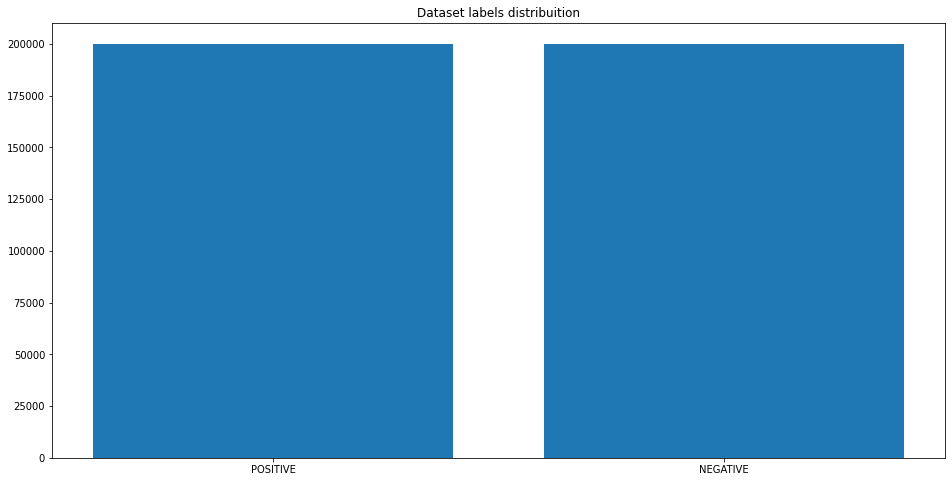

In [83]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [84]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [85]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [86]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [87]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: user 13 s, sys: 2.96 ms, total: 13 s
Wall time: 13 s


In [88]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 320000
TEST size: 80000


In [89]:
%%time
documents = [_text.split() for _text in df_train.text] 

CPU times: user 803 ms, sys: 71.9 ms, total: 875 ms
Wall time: 876 ms


In [90]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [91]:
w2v_model.build_vocab(documents)

In [92]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 13413


In [93]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

CPU times: user 4min 20s, sys: 543 ms, total: 4min 20s
Wall time: 2min 13s


(63205643, 73879552)

In [94]:
w2v_model.most_similar("peace")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('relaxation', 0.42266565561294556),
 ('weary', 0.3482041358947754),
 ('blessings', 0.32827872037887573),
 ('peacefully', 0.313678503036499),
 ('farrah', 0.3011729419231415),
 ('prayers', 0.27329856157302856),
 ('bless', 0.26331016421318054),
 ('goodnight', 0.26001664996147156),
 ('affair', 0.25833308696746826),
 ('jonathanrknight', 0.2579716145992279)]

In [95]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 119938
CPU times: user 3.6 s, sys: 104 ms, total: 3.7 s
Wall time: 3.61 s


In [96]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: user 5.41 s, sys: 111 ms, total: 5.52 s
Wall time: 5.52 s


In [97]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [98]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (320000, 1)
y_test (80000, 1)


In [99]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (320000, 300)
y_train (320000, 1)

x_test (80000, 300)
y_test (80000, 1)


In [100]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(119938, 300)


In [101]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

In [102]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          35981400  
_________________________________________________________________
dropout_1 (Dropout)          (None, 300, 300)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 36,141,901
Trainable params: 160,501
Non-trainable params: 35,981,400
_________________________________________________________________


In [103]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [106]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [107]:
df.shape, x_train.shape, y_train.shape

((400000, 6), (320000, 300), (320000, 1))

In [108]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=2048,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/8
141/141 [==============================] - 161s 1s/step - loss: 0.5053 - accuracy: 0.7497 - val_loss: 0.4867 - val_accuracy: 0.7669
Epoch 2/8
141/141 [==============================] - 162s 1s/step - loss: 0.4972 - accuracy: 0.7545 - val_loss: 0.4865 - val_accuracy: 0.7682
Epoch 3/8
141/141 [==============================] - 166s 1s/step - loss: 0.4919 - accuracy: 0.7591 - val_loss: 0.4847 - val_accuracy: 0.7694
Epoch 4/8
141/141 [==============================] - 163s 1s/step - loss: 0.4879 - accuracy: 0.7606 - val_loss: 0.4795 - val_accuracy: 0.7720
Epoch 5/8
141/141 [==============================] - 164s 1s/step - loss: 0.4841 - accuracy: 0.7634 - val_loss: 0.4781 - val_accuracy: 0.7728
Epoch 6/8
141/141 [==============================] - 160s 1s/step - loss: 0.4820 - accuracy: 0.7650 - val_loss: 0.4760 - val_accuracy: 0.7747
Epoch 7/8
141/141 [==============================] - 160s 1s/step - loss: 0.4791 - accuracy: 0.7667 - val_loss: 0.4726 - val_accuracy: 0.7758
Epoch 

In [109]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

79/79 [==============================] - 14s 173ms/step - loss: 0.4760 - accuracy: 0.7755

ACCURACY: 0.775475025177002
LOSS: 0.47599634528160095
CPU times: user 13.1 s, sys: 861 ms, total: 14 s
Wall time: 13.8 s


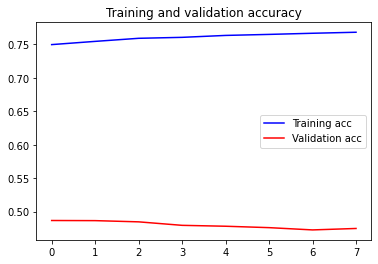

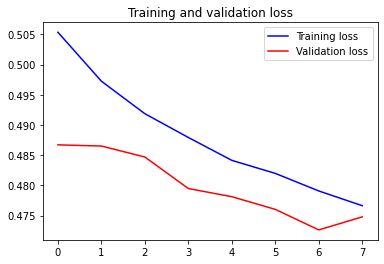

In [110]:
acc = history.history['accuracy']
val_acc = history.history['val_loss']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [111]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [112]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [113]:
predict("I love the music")

{'elapsed_time': 0.28885912895202637,
 'label': 'POSITIVE',
 'score': 0.982218861579895}

In [114]:
predict("i don't know what i'm doing")

{'elapsed_time': 0.0877985954284668,
 'label': 'NEGATIVE',
 'score': 0.39202985167503357}

In [115]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

10/10 [==============================] - 12s 1s/step
CPU times: user 8.22 s, sys: 4.44 s, total: 12.7 s
Wall time: 12.4 s


In [116]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

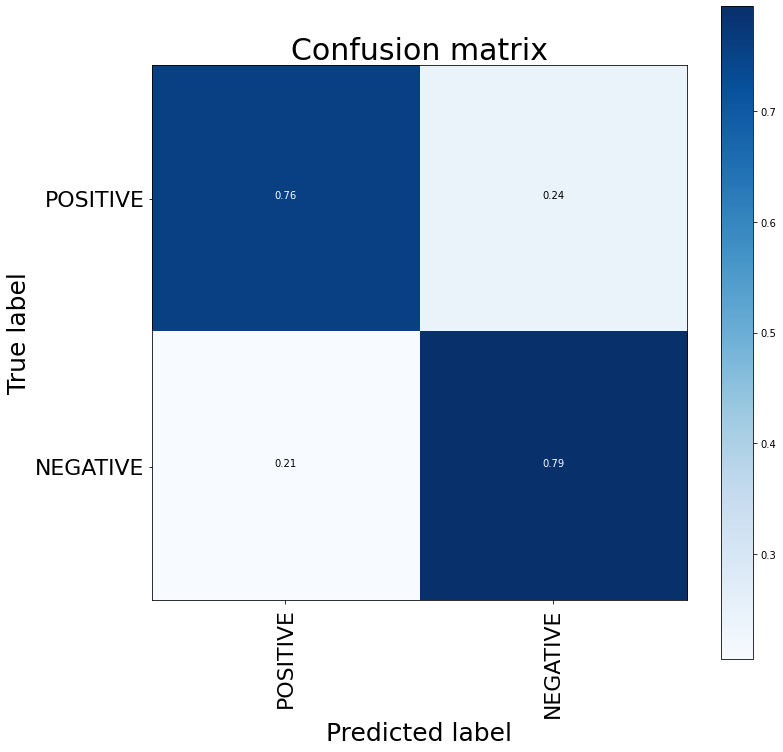

CPU times: user 402 ms, sys: 5.97 ms, total: 408 ms
Wall time: 414 ms


In [117]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

In [118]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.79      0.76      0.77     39883
    POSITIVE       0.77      0.79      0.78     40117

    accuracy                           0.78     80000
   macro avg       0.78      0.78      0.78     80000
weighted avg       0.78      0.78      0.78     80000



In [119]:
accuracy_score(y_test_1d, y_pred_1d)

0.775475

In [120]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)